In [1]:
# ! pip install tensorflow_similarity
# ! pip install --upgrade tensorflow
# ! pip install numpy==1.21
# ! pip install opencv-python

In [1]:
import gc
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tabulate import tabulate
import cv2

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_similarity as tfsim  # main package



c:\Users\deela\anaconda3\envs\tff\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

tfsim.utils.tf_cap_memory()

# Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()

print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.9.1
TensorFlow Similarity 0.16.6


In [3]:
IMG_SIZE = [224, 64]

TRAIN_PATH = '../../datasets/signatures/full_org/'


---
Dataset & Dataloader

In [4]:
file_paths, labels, instances = [], [], []
for f in os.listdir(TRAIN_PATH):
    try:
        dataT, label, instance = f.split('.')[0].split('_')
        label = int(label)
        fpath = os.path.join(TRAIN_PATH, f)
        file_paths.append(fpath)
        labels.append(label)
        instances.append(instance)
    except:
        print(f)


Thumbs.db


In [5]:
from sklearn.model_selection import train_test_split

data_df = pd.DataFrame({'file_path': file_paths, 'label': labels, 'instance': instances})
X, y = data_df.loc[:, ['file_path']], data_df.loc[:, 'label']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42, stratify=y)

X_train['label'] = y_train
X_test['label'] = y_test

In [6]:
X_train.head()

,file_path,label
1171,../../datasets/signatures/full_org/original_54...,54
317,../../datasets/signatures/full_org/original_22...,22
341,../../datasets/signatures/full_org/original_23...,23
440,../../datasets/signatures/full_org/original_27...,27
500,../../datasets/signatures/full_org/original_29...,29


In [11]:
len(set(y))

55

In [12]:
1320 - 884

436

In [7]:
def load_image(path):
    image = cv2.imread(path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    res_image = cv2.resize(gray_image, IMG_SIZE)
    return res_image

(-0.5, 223.5, 63.5, -0.5)

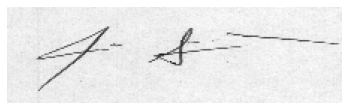

In [8]:
sample_image_path = os.path.join(TRAIN_PATH, 'original_1_1.png')
sample_image = load_image(sample_image_path)
plt.imshow(sample_image, cmap='gray')
plt.axis('off')

In [9]:
train_images, train_labels = [], []
zip_data = X_train.loc[:, ['file_path', 'label']].values.tolist()
for i, l in zip_data:
    train_images.append(np.transpose(load_image(i), [1,0]))
    train_labels.append(l)
train_images, train_labels = np.array(train_images), np.array(train_labels)

In [10]:
test_images, test_labels = [], []
zip_data = X_test.loc[:, ['file_path', 'label']].values.tolist()
for i,l in zip_data:
    test_images.append(np.transpose(load_image(i), [1,0]))
    test_labels.append(l)
test_images, test_labels = np.array(test_images), np.array(test_labels)

In [12]:
train_images.shape

(884, 224, 64)

In [30]:
CLASSES = list(X_train['label'].unique())
NUM_CLASSES = len(CLASSES)  # @param {type: "slider", min: 1, max: 10}
CLASSES_PER_BATCH = 10
EXAMPLES_PER_CLASS = 10  # @param {type:"integer"}
STEPS_PER_EPOCH = 300  # @param {type:"integer"}

sampler = tfsim.samplers.MultiShotMemorySampler(
    train_images,
    train_labels,
    classes_per_batch=CLASSES_PER_BATCH,
    examples_per_class_per_batch=EXAMPLES_PER_CLASS,
    class_list=CLASSES[:NUM_CLASSES],  # Only use the first 6 classes for training.
    steps_per_epoch=STEPS_PER_EPOCH,
)


The initial batch size is 100 (10 classes * 10 examples per class) with 0 augmenters


indexing classes: 100%|██████████| 884/884 [00:00<00:00, 890005.94it/s]


In [31]:
X_ms_batch, y_ms_batch = sampler.generate_batch(100)

In [32]:
X_ms_batch.shape

TensorShape([100, 224, 64])

In [33]:
y_ms_batch

<tf.Tensor: shape=(100,), dtype=int32, numpy=
array([34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 37, 37, 37, 37,
       37, 37, 37, 37, 37, 37, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 43, 43, 43, 43, 43, 43, 43, 43,
       43, 43, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 42, 42, 42, 42, 42,
       42, 42, 42, 42, 42, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32])>

In [35]:
def get_model(input_shape=(128, 48), h_cell=32, latent_size=32, n_classes=26, n_obj=10, emb_size=64, linear_k=3):
    input_layer = layers.Input(shape=input_shape)
    forward_layer = layers.LSTM(h_cell//2, return_sequences=True)
    x = layers.Bidirectional(forward_layer, input_shape=input_shape)(input_layer)
    x = layers.LSTM(latent_size, activation='tanh',
                    return_sequences=True, go_backwards=True)(x)
    x = layers.Conv1D(n_classes, linear_k, activation='tanh')(x)
    x = layers.Permute((2, 1))(x)
    x = layers.Conv1D(n_obj, 1, activation='tanh')(x)
    x = layers.Permute((2, 1))(x)
    x = layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = tfsim.layers.MetricEmbedding(64)(x)
    return tfsim.models.SimilarityModel(input_layer, outputs)


model = get_model(input_shape=IMG_SIZE)
model.summary()

Model: "similarity_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 64)]         0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 224, 32)          10368     
 nal)                                                            
                                                                 
 lstm_5 (LSTM)               (None, 224, 32)           8320      
                                                                 
 conv1d_4 (Conv1D)           (None, 222, 26)           2522      
                                                                 
 permute_4 (Permute)         (None, 26, 222)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 26, 10)            2230      
                                                

In [17]:
sample_input = tf.random.uniform(shape=(8, 224, 64))
sample_output = model(sample_input)

In [18]:
sample_output.shape

TensorShape([8, 64])

In [34]:
distance = "cosine"  # @param ["cosine", "L2", "L1"]{allow-input: false}
loss = tfsim.losses.MultiSimilarityLoss(distance=distance)

In [38]:
LR = 0.0005  # @param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss)

Distance metric automatically set to cosine use the distance arg to override.


In [39]:
EPOCHS = 10  # @param {type:"integer"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(test_images, test_labels))

Epoch 1/10
300/300 [==============================] - 16s 37ms/step - loss: 1.2180 - val_loss: 0.1795
Warmup complete
Epoch 2/10
300/300 [==============================] - 10s 34ms/step - loss: 1.0213 - val_loss: 0.1553
Epoch 3/10
300/300 [==============================] - 10s 33ms/step - loss: 0.8578 - val_loss: 0.1438
Epoch 4/10
300/300 [==============================] - 10s 32ms/step - loss: 0.7226 - val_loss: 0.1367
Epoch 5/10
300/300 [==============================] - 10s 32ms/step - loss: 0.5786 - val_loss: 0.1324
Epoch 6/10
300/300 [==============================] - 10s 33ms/step - loss: 0.4667 - val_loss: 0.1262
Epoch 7/10
300/300 [==============================] - 10s 33ms/step - loss: 0.3064 - val_loss: 0.1195
Epoch 8/10
300/300 [==============================] - 10s 33ms/step - loss: 0.2147 - val_loss: 0.1230
Epoch 9/10
300/300 [==============================] - 10s 33ms/step - loss: 0.1737 - val_loss: 0.1219
Epoch 10/10
300/300 [==============================] - 10s 34ms/st

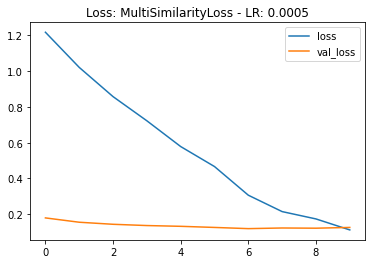

In [40]:
# expect loss: 0.14 / val_loss: 0.33
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

In [41]:
x_index, y_index = tfsim.samplers.select_examples(train_images, train_labels, CLASSES, 6)
model.reset_index()
model.index(x_index, y_index, data=x_index)

gather examples: 100%|██████████| 330/330 [00:00<?, ?it/s]


[Indexing 330 points]
|-Computing embeddings
11/11 [==============================] - 1s 30ms/step
|-Storing data points in key value store
|-Adding embeddings to index.
|-Building index.


gather examples: 100%|██████████| 55/55 [00:00<?, ?it/s]

1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 261ms/step

Performing NN search



Building NN list: 100%|██████████| 55/55 [00:00<00:00, 55148.63it/s]


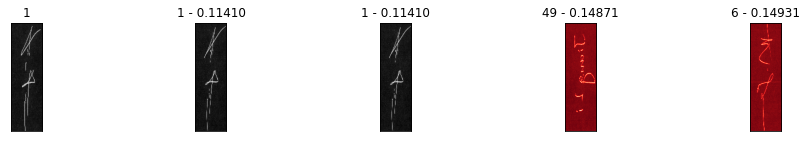

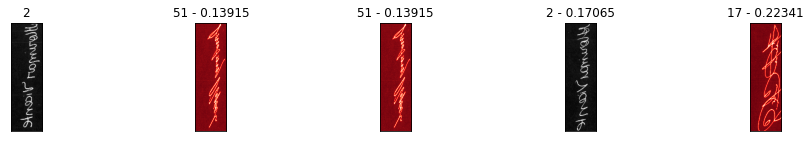

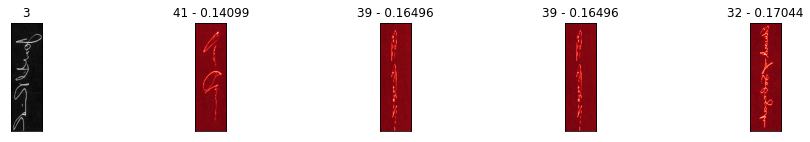

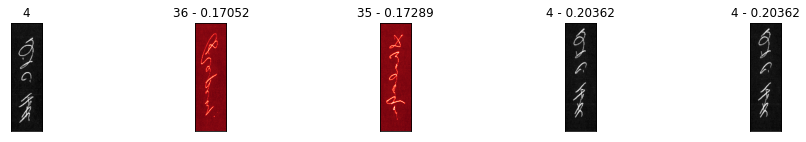

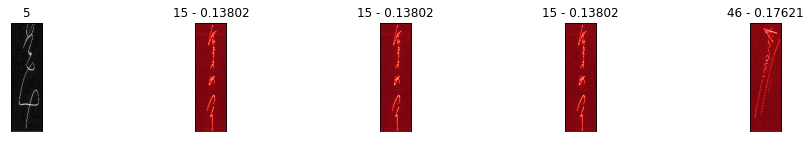

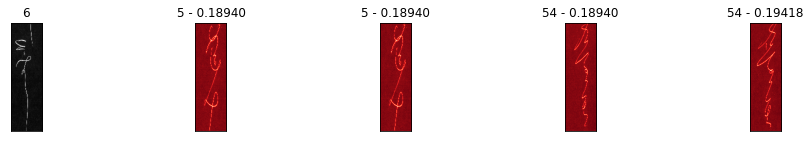

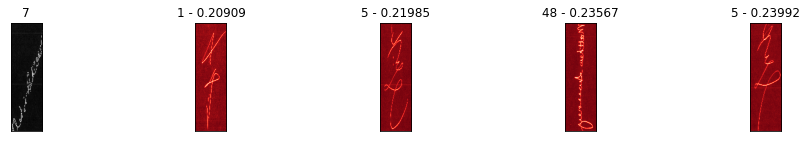

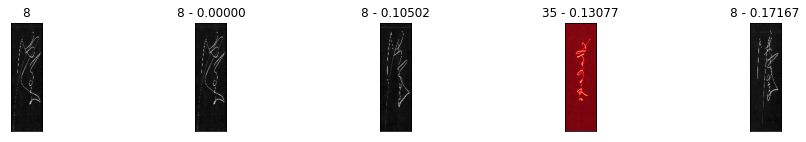

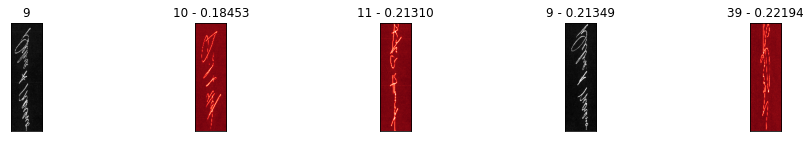

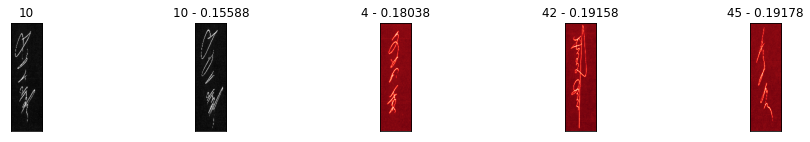

In [24]:
# re-run to test on other examples
num_neighbors = 4
num_samples = 10
# select
x_display, y_display = tfsim.samplers.select_examples(train_images, train_labels, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
i = 0
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")
    i += 1
    if i == num_samples:
        break

gather examples: 100%|██████████| 55/55 [00:00<?, ?it/s]


2/2 [==============================] - 0s 32ms/step

Performing NN search



Building NN list: 100%|██████████| 55/55 [00:00<00:00, 55201.42it/s]


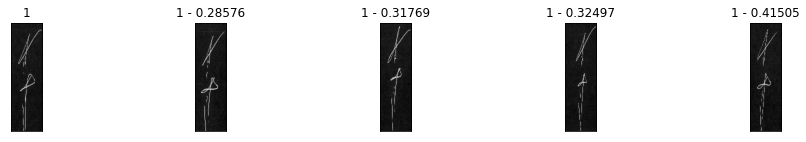

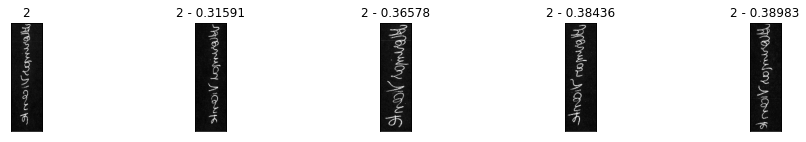

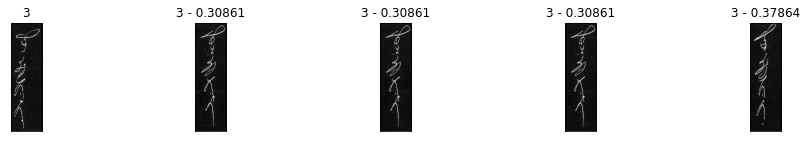

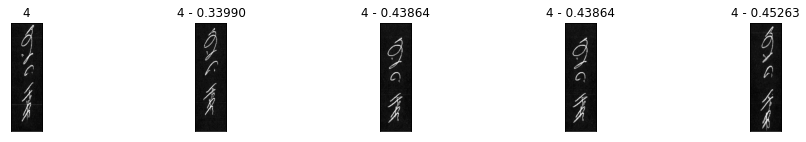

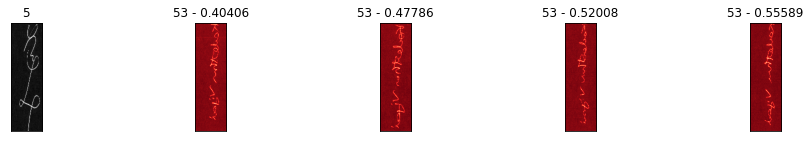

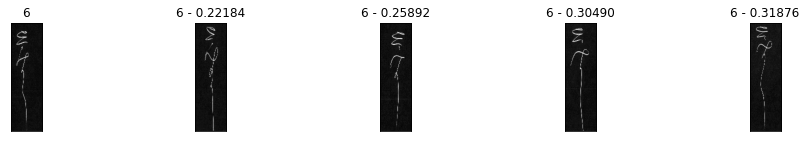

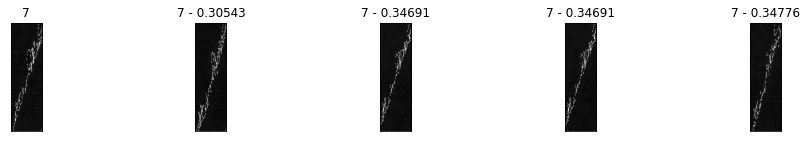

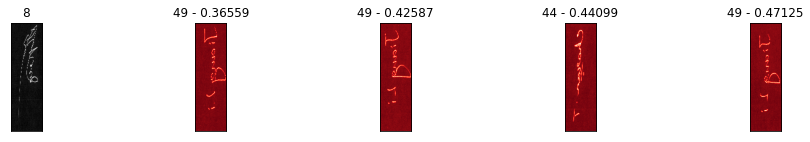

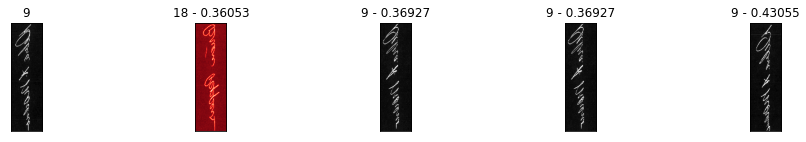

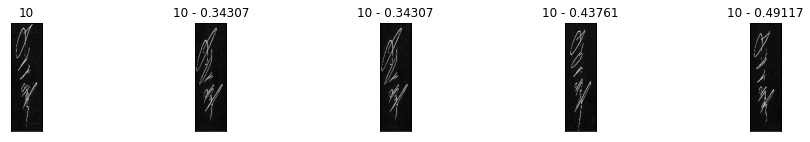

In [42]:
# re-run to test on other examples
num_neighbors = 4
num_samples = 10
# select
x_display, y_display = tfsim.samplers.select_examples(test_images, test_labels, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
i = 0
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")
    i += 1
    if i == num_samples:
        break

In [43]:
num_calibration_samples = 800  # @param {type:"integer"}
calibration = model.calibrate(
    train_images[:num_calibration_samples],
    train_labels[:num_calibration_samples],
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)

25/25 [==============================] - 0s 17ms/step

Performing NN search



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 595.17it/s]


 name       value    distance    precision    recall    binary_accuracy    f1
-------  -------  ----------  -----------  --------  -----------------  ----
optimal        1    0.393823            1         1                  1     1


In [47]:
num_calibration_samples = 200  # @param {type:"integer"}
calibration = model.calibrate(
    test_images[:num_calibration_samples],
    test_labels[:num_calibration_samples],
    extra_metrics=["precision", "recall", "binary_accuracy"],
    verbose=1,
)

7/7 [==============================] - 0s 42ms/step

Performing NN search



Evaluating: 100%|██████████| 4/4 [00:00<00:00, 593.30it/s]


 name        value    distance    precision    recall    binary_accuracy        f1
-------  --------  ----------  -----------  --------  -----------------  --------
optimal  0.866279    0.475551     0.776042  0.980263              0.745  0.866279


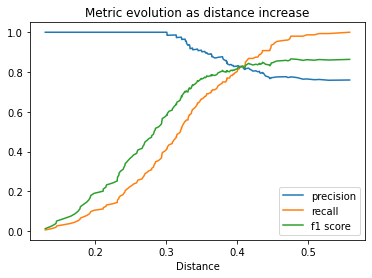

In [48]:
fig, ax = plt.subplots()
x = calibration.thresholds["distance"]
ax.plot(x, calibration.thresholds["precision"], label="precision")
ax.plot(x, calibration.thresholds["recall"], label="recall")
ax.plot(x, calibration.thresholds["f1"], label="f1 score")
ax.legend()
ax.set_title("Metric evolution as distance increase")
ax.set_xlabel("Distance")
plt.show()

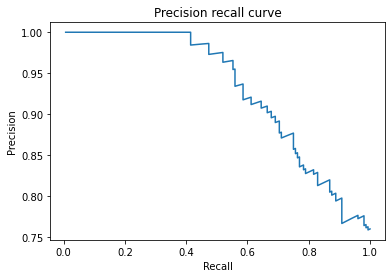

In [49]:
fig, ax = plt.subplots()
ax.plot(calibration.thresholds["recall"], calibration.thresholds["precision"])
ax.set_title("Precision recall curve")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
plt.show()

In [50]:
num_matches = 10  # @param {type:"integer"}
j = 200
matches = model.match(test_images[j:j+num_matches], cutpoint="optimal")
rows = []
for idx, match in enumerate(matches):
    rows.append([match, test_labels[idx], match == test_labels[idx]])
print(tabulate(rows, headers=["Predicted", "Expected", "Correct"]))

1/1 [==============================] - 0s 30ms/step
  Predicted    Expected    Correct
-----------  ----------  ---------
         15          46          0
          4          36          0
         38          44          0
         27          12          0
         36          32          0
          6           1          0
         12           6          0
         -1          46          0
         30          25          0
         25           3          0


gather examples: 100%|██████████| 2750/2750 [00:00<00:00, 920170.40it/s]


86/86 [==============================] - 1s 12ms/step


<Figure size 1440x1440 with 0 Axes>

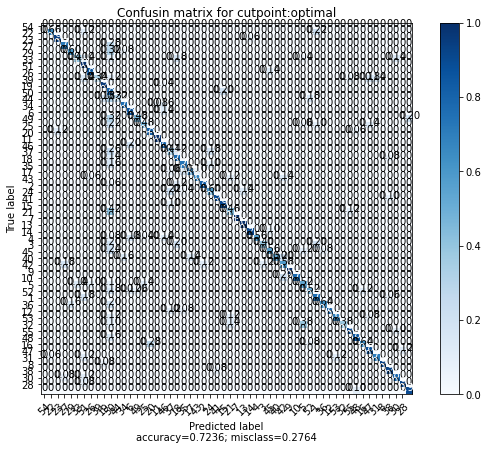

In [52]:
# used to label in images in the viz_neighbors_imgs plots
# note we added a 11th classes for unknown
labels = [str(c) for c in CLASSES]
num_examples_per_class = 50
cutpoint = "optimal"

x_confusion, y_confusion = tfsim.samplers.select_examples(test_images, test_labels, CLASSES, num_examples_per_class)

plt.figure(figsize=(20, 20))
matches = model.match(x_confusion, cutpoint=cutpoint, no_match_label=10)
cm = tfsim.visualization.confusion_matrix(
    matches,
    y_confusion,
    labels=labels,
    title="Confusin matrix for cutpoint:%s" % cutpoint,
)

In [53]:
model.index_summary()

[Info]
------------------  ------
distance            cosine
key value store     memory
search algorithm    nmslib
evaluator           memory
index size          330
calibrated          True
calibration_metric  f1
embedding_output
------------------  ------



[Performance]
-----------  --------------
num lookups  6575
min             9.92368e-05
max             9.92368e-05
avg             9.92368e-05
median          9.92368e-05
stddev          1.35525e-20
-----------  --------------


gather examples: 100%|██████████| 55/55 [00:00<?, ?it/s]


2/2 [==============================] - 0s 30ms/step

Performing NN search



Building NN list: 100%|██████████| 55/55 [00:00<00:00, 57441.91it/s]


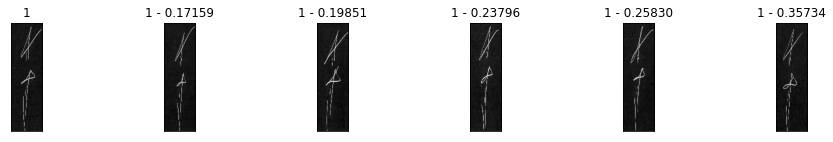

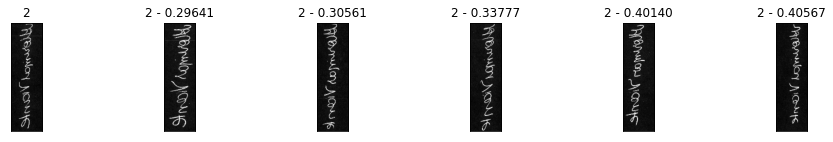

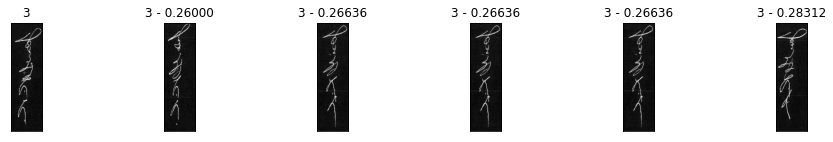

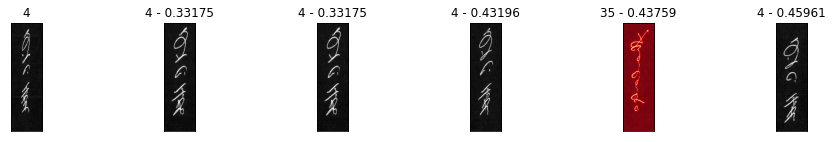

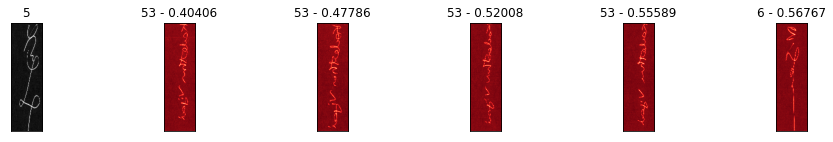

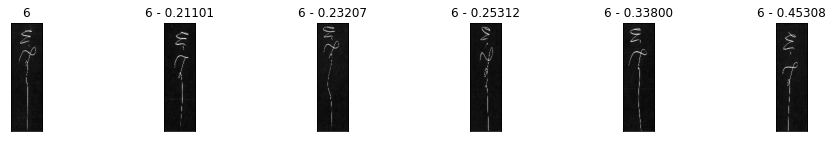

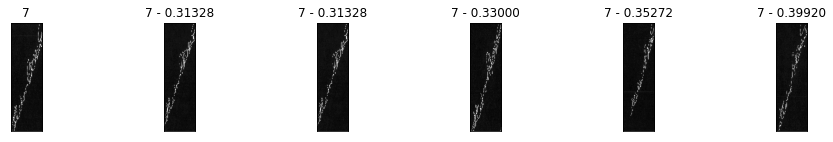

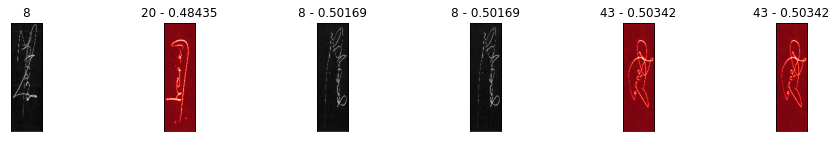

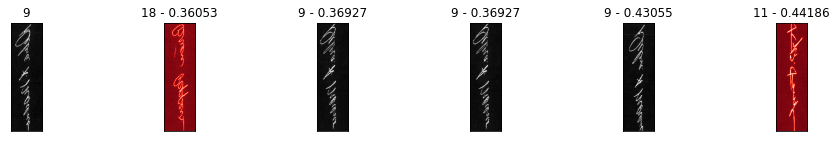

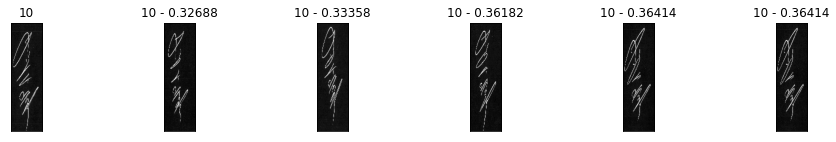

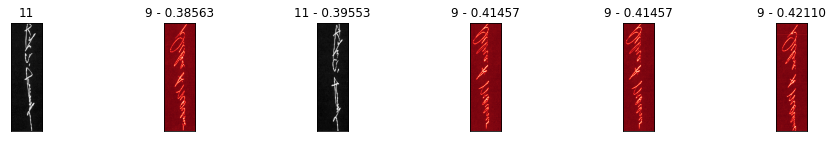

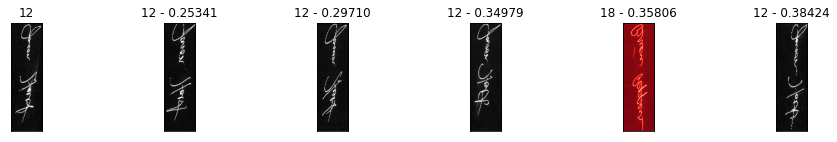

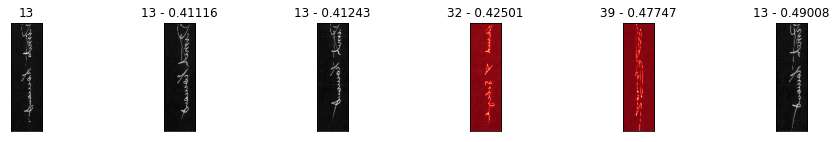

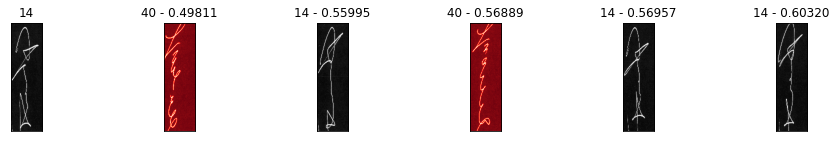

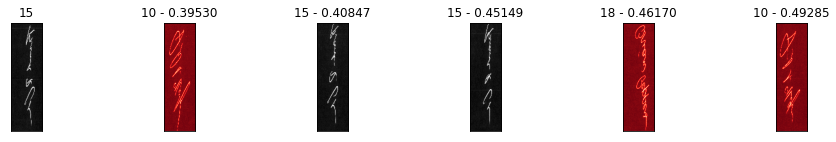

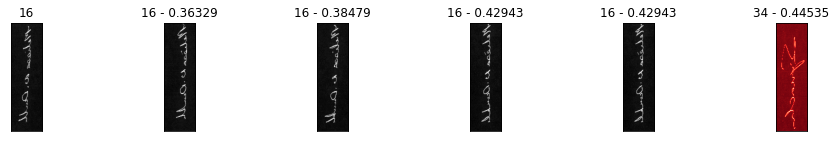

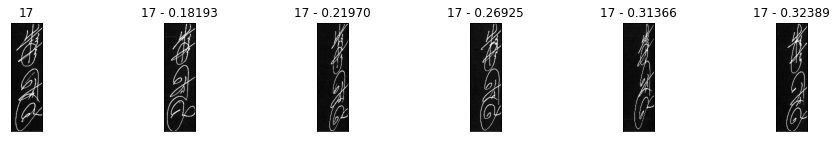

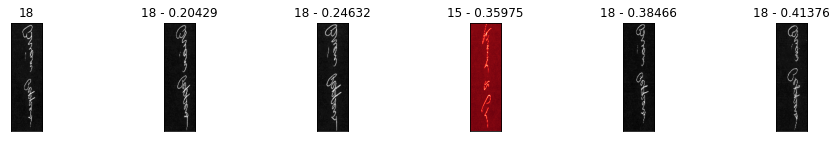

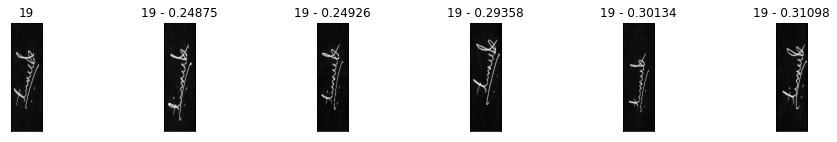

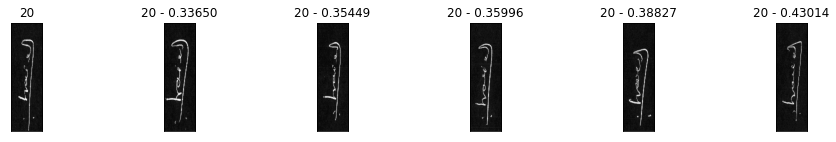

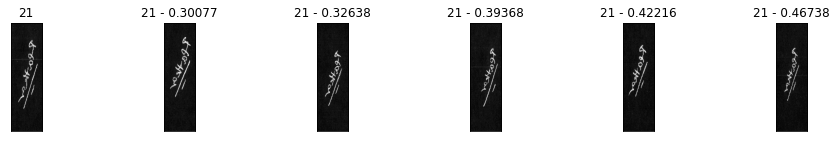

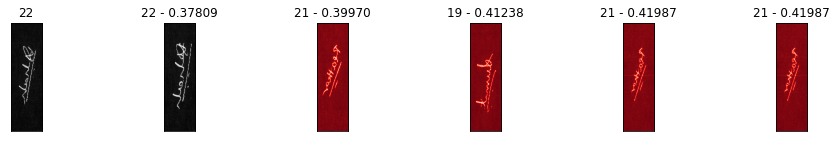

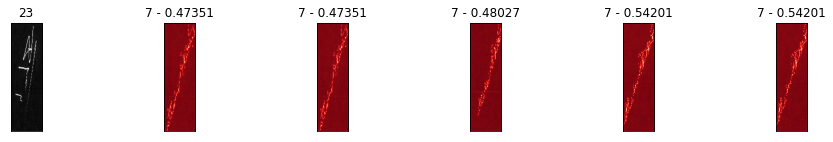

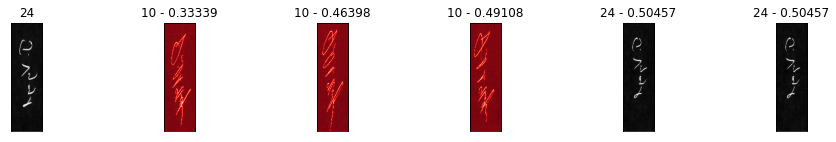

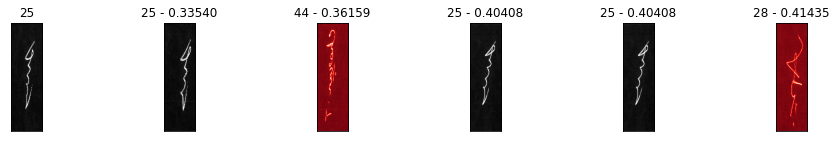

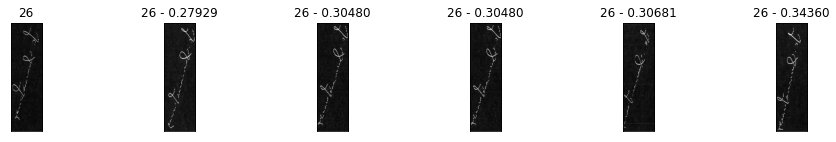

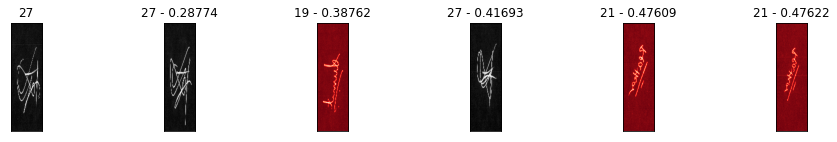

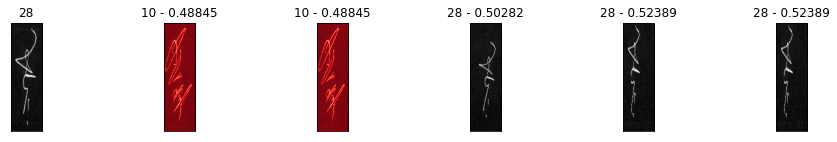

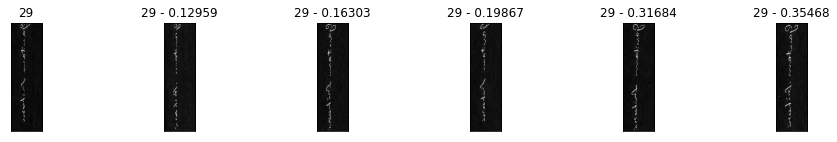

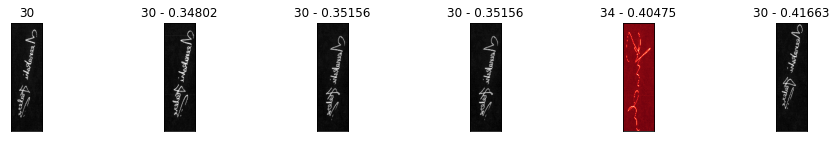

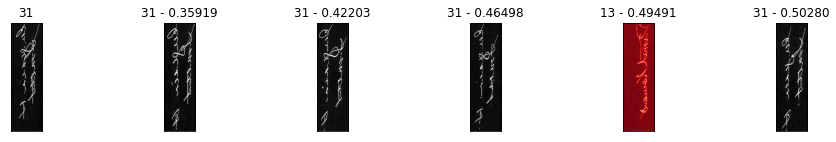

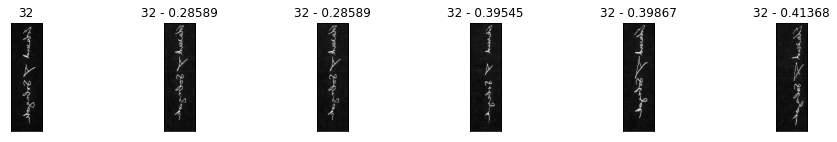

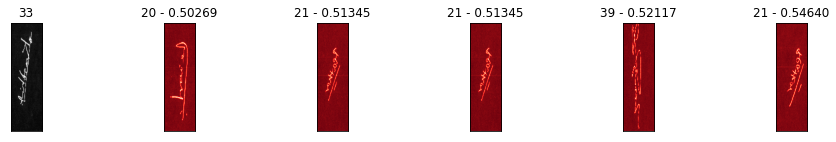

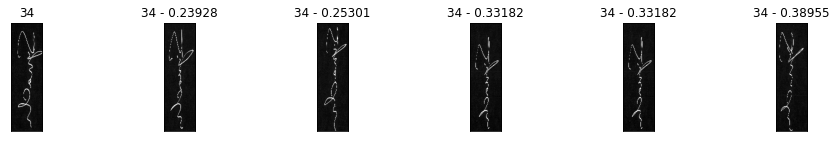

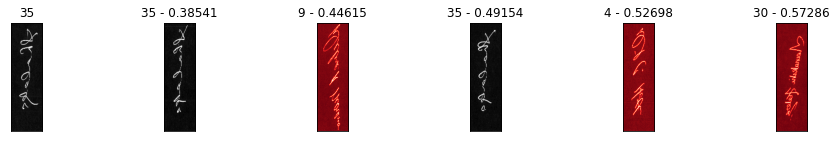

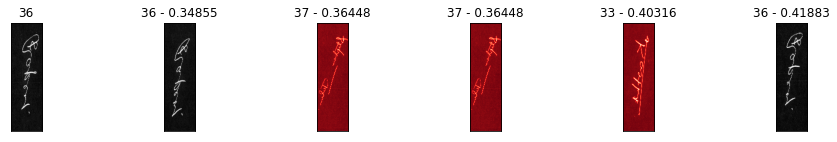

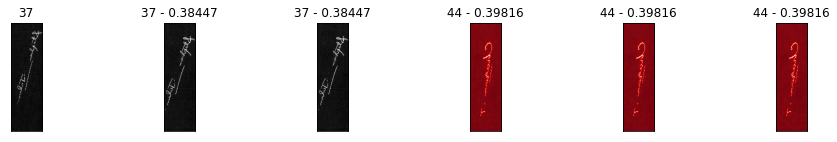

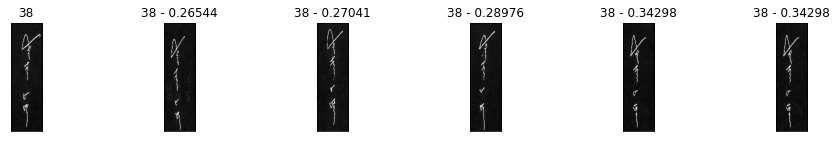

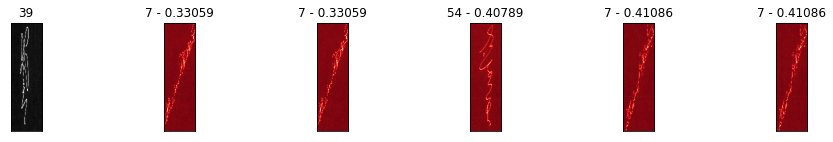

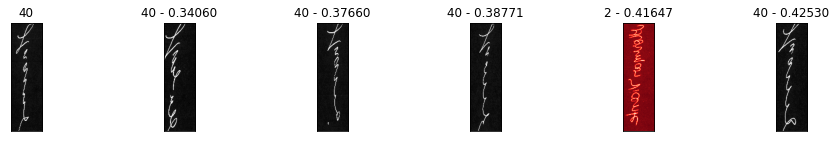

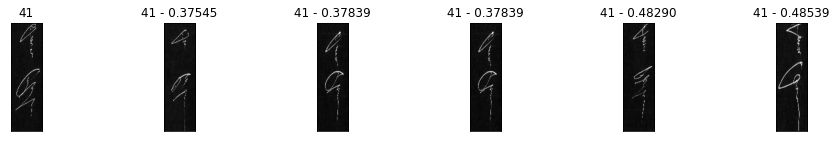

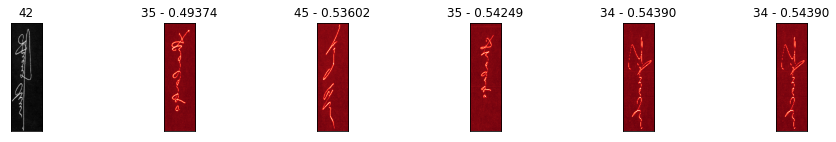

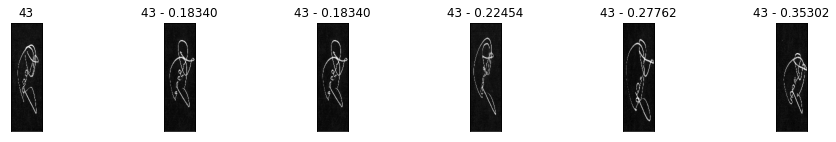

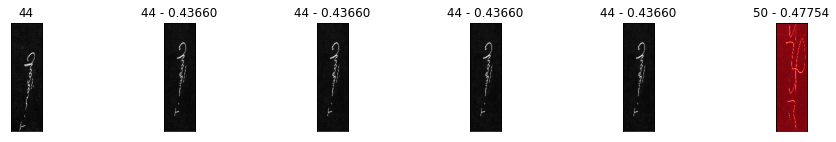

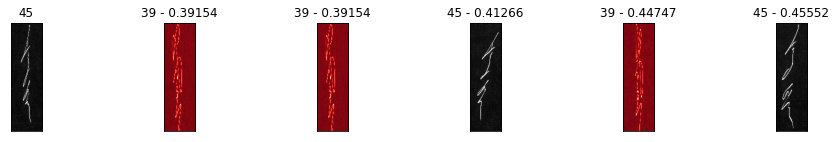

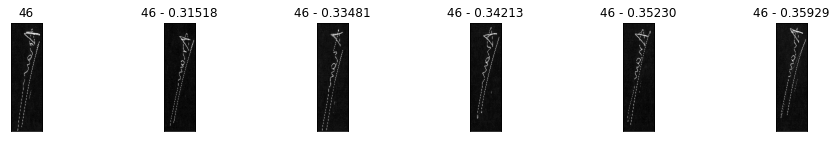

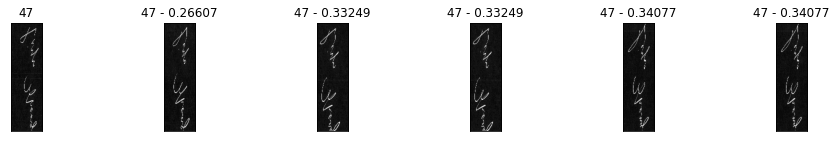

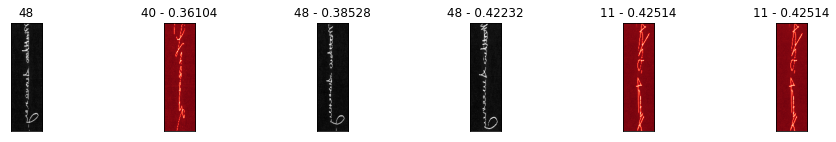

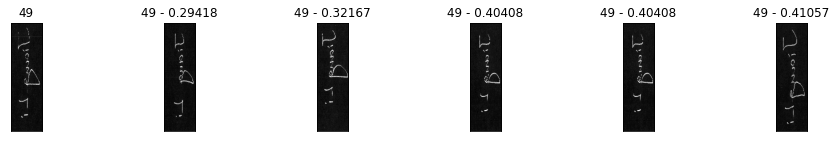

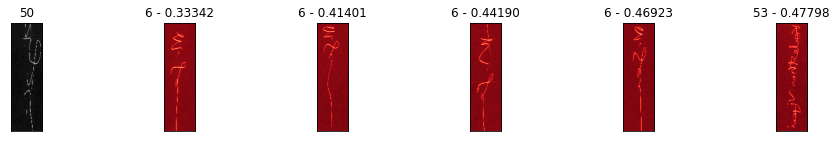

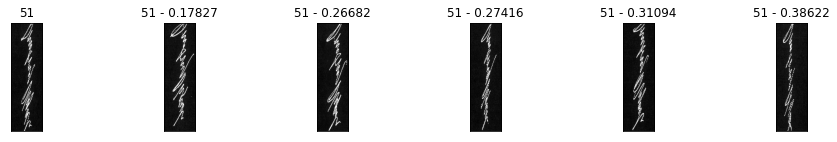

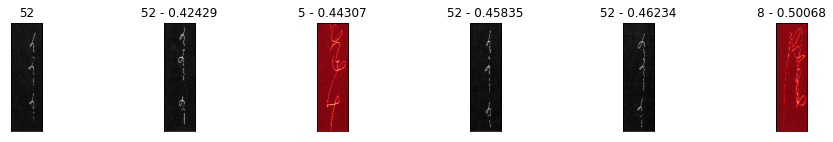

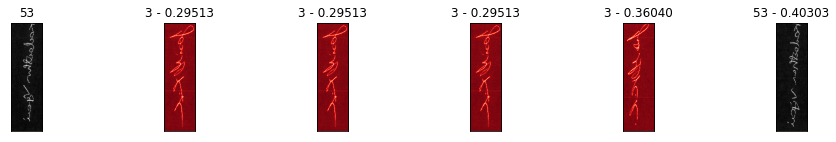

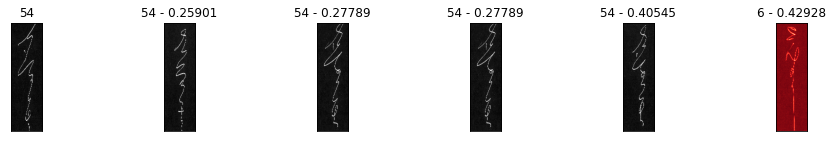

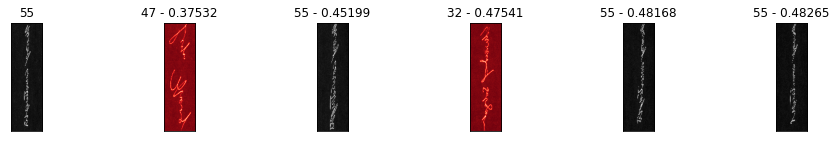

In [54]:
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(test_images, test_labels, CLASSES, 1)

# lookup the nearest neighbors
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")